# 1. Introduction

Ask a home buyer to describe their dream house, and they probably won’t begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition’s dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.
With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.
The potential for creative feature engineering provides a rich opportunity for fun and learning. This dataset lends itself to advanced regression techniques like random forests and gradient boosting with the popular XGBoost library.

https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques


# 2. Data Loading & Preparation
## 2.1 Load up Python libraries

In [1]:
import numpy as np
import pandas as pd 
from pandas.api.types import CategoricalDtype
import math
import re
import warnings
from pathlib import Path
import pprint
from IPython.display import HTML, display

# Plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Stats and ML libraries
import scipy.stats as stats
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
import optuna
import lightgbm as lgb

# Pandas display formatting - to show more columns
pd.options.display.max_rows = 500
pd.options.display.max_columns = 500


## 2.2 Read data from csv

In [2]:
## load training data
# na_filter - Pandas impute NA as missing, but here it means either "No" for cateoricals or missing for numerics, so we have to handle this manually
house_train = pd.read_csv(Path('data/train.csv'), na_filter=False)
house_test = pd.read_csv(Path('data/test.csv'), na_filter=False)

## 2.3 Understand the data

In [3]:
print(f"Training shape: {house_train.shape}")
print(f"Testing shape: {house_test.shape}")

Training shape: (1460, 81)
Testing shape: (1459, 80)


In [4]:
house_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             1460 non-null   int64 
 1   MSSubClass     1460 non-null   int64 
 2   MSZoning       1460 non-null   object
 3   LotFrontage    1460 non-null   object
 4   LotArea        1460 non-null   int64 
 5   Street         1460 non-null   object
 6   Alley          1460 non-null   object
 7   LotShape       1460 non-null   object
 8   LandContour    1460 non-null   object
 9   Utilities      1460 non-null   object
 10  LotConfig      1460 non-null   object
 11  LandSlope      1460 non-null   object
 12  Neighborhood   1460 non-null   object
 13  Condition1     1460 non-null   object
 14  Condition2     1460 non-null   object
 15  BldgType       1460 non-null   object
 16  HouseStyle     1460 non-null   object
 17  OverallQual    1460 non-null   int64 
 18  OverallCond    1460 non-null

In [5]:
house_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NA,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NA,NA,NA,0,12,2008,WD,Normal,250000


In [6]:
house_train.describe()

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,10516.828082,6.099315,5.575342,1971.267808,1984.865753,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,9981.264932,1.382997,1.112799,30.202904,20.645407,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## 2.3 Data Types
Pandas guesses the types of all the columns when it scans a csv. It does a reasonable job most of the time, but we need to check carefully.

### 2.3.1 Build a categorical data reference

In [7]:
# Derive categorical features and all their possible categories from data_description.txt
categorical_lookup = {}
with open(Path('data/data_description.txt'), "r", encoding="utf-8") as f:
    lines = f.readlines()

    for line in lines:
        if (not re.search(r"^\s", line)) & (": " in line):
            # if line doesnt start with space/tab, and contains :, its a key
            col, _ = line.strip().split(":")
            categorical_lookup[col] = []
        else:
            # else if its longer than zero it's a value
            if len(line.strip()) > 0:
                val = line.strip().split("\t")[0].strip()
                categorical_lookup[col].append(val)
                
# Print some formatted results
categorical_lookup = {k:categorical_lookup[k] for k in list(categorical_lookup.keys()) if len(categorical_lookup[k]) > 0}
for key in categorical_lookup.keys():
    print(f"{key}: {categorical_lookup[key][:5]}")

MSSubClass: ['20', '30', '40', '45', '50']
MSZoning: ['A', 'C', 'FV', 'I', 'RH']
Street: ['Grvl', 'Pave']
Alley: ['Grvl', 'Pave', 'NA']
LotShape: ['Reg', 'IR1', 'IR2', 'IR3']
LandContour: ['Lvl', 'Bnk', 'HLS', 'Low']
Utilities: ['AllPub', 'NoSewr', 'NoSeWa', 'ELO']
LotConfig: ['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3']
LandSlope: ['Gtl', 'Mod', 'Sev']
Neighborhood: ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr']
Condition1: ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn']
Condition2: ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn']
BldgType: ['1Fam', '2FmCon', 'Duplx', 'TwnhsE', 'TwnhsI']
HouseStyle: ['1Story', '1.5Fin', '1.5Unf', '2Story', '2.5Fin']
OverallQual: ['10', '9', '8', '7', '6']
OverallCond: ['10', '9', '8', '7', '6']
RoofStyle: ['Flat', 'Gable', 'Gambrel', 'Hip', 'Mansard']
RoofMatl: ['ClyTile', 'CompShg', 'Membran', 'Metal', 'Roll']
Exterior1st: ['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock']
Exterior2nd: ['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock']
MasVnrT

Looks like thse contain ordinal and nominal variables as well some that could be converted to numerics (OverallQual, OverallCond).

Other columns contain values missing from the lookup (MSSubClass, MSZoning, Neighborhood, BldgType, Exterior2nd, SaleType).

We need to look at these individually to understand them.

### 2.3.2 Fixing Categories and names

In [8]:
# Check that the values in the category lookup match those in the data
def test_missing_categories():
    missing_categories = {}
    for col in categorical_lookup.keys():
        cat_diff = list(set(house_train[col].dropna().unique()) - set(categorical_lookup[col]))
        
        # level_diff = list(set([str(i) for i in house_train[varname] if str(i) != "nan"]) - set(categorical_lookup[varname]))
        if len(cat_diff) > 0:
            missing_categories[col] = cat_diff
    return(missing_categories)

pprint.pprint(test_missing_categories())

{'BldgType': ['Twnhs', '2fmCon', 'Duplex'],
 'Electrical': ['NA'],
 'Exterior2nd': ['Wd Shng', 'CmentBd', 'Brk Cmn'],
 'MSSubClass': [160, 70, 40, 75, 45, 190, 80, 50, 20, 85, 180, 120, 90, 60, 30],
 'MSZoning': ['C (all)'],
 'MasVnrType': ['NA'],
 'Neighborhood': ['NAmes'],
 'OverallCond': [1, 2, 3, 4, 5, 6, 7, 8, 9],
 'OverallQual': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}


Above we saw that certain of the values that occur in the data set, are missing from the categorical lookup, lets fix them.

We can automate a lot of things, but some things need to be done manually, especially during EDA.

In [9]:
# the NA values in Electrical and MasVnrType are different, they represent missing data
# replace these values in the data set.
house_train["MasVnrType"] = house_train["MasVnrType"].replace('NA', None)
house_test["MasVnrType"] = house_test["MasVnrType"].replace('NA', None)
house_train["Electrical"] = house_train["Electrical"].replace('NA', None)
house_test["Electrical"] = house_test["Electrical"].replace('NA', None)

In [10]:
# The remainder of the categorical errors appear to be typos in the lookup, so lets update the lookup
# small helper to replace values in the category lookup
def cat_val_replacer(colname, old, new):
    try:
        idx = categorical_lookup[colname].index(old)
        categorical_lookup[colname][idx] = new
    except:
        pass

In [11]:
# MSZoning
print(test_missing_categories()["MSZoning"])
# print(house_train["MSZoning"].unique())
# print(house_test["MSZoning"].unique())
print(categorical_lookup["MSZoning"])

['C (all)']
['A', 'C', 'FV', 'I', 'RH', 'RL', 'RP', 'RM']


In [12]:
cat_val_replacer("MSZoning", 'C', 'C (all)')
print(categorical_lookup["MSZoning"])

['A', 'C (all)', 'FV', 'I', 'RH', 'RL', 'RP', 'RM']


In [13]:
# Neighborhood
print(test_missing_categories()["Neighborhood"])
# print(house_train["Neighborhood"].unique())
# print(house_test["Neighborhood"].unique())
print(categorical_lookup["Neighborhood"])

['NAmes']
['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'Names', 'NoRidge', 'NPkVill', 'NridgHt', 'NWAmes', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker']


In [14]:
cat_val_replacer("Neighborhood", 'Names', 'NAmes')
print(categorical_lookup["Neighborhood"])

['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NoRidge', 'NPkVill', 'NridgHt', 'NWAmes', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker']


In [15]:
# BldgType
print(test_missing_categories()["BldgType"])
print(house_train["BldgType"].unique())
print(house_test["BldgType"].unique())
print(categorical_lookup["BldgType"])

['Twnhs', '2fmCon', 'Duplex']
['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
['1Fam' 'TwnhsE' 'Twnhs' 'Duplex' '2fmCon']
['1Fam', '2FmCon', 'Duplx', 'TwnhsE', 'TwnhsI']


In [16]:
cat_val_replacer("BldgType", '2FmCon', '2fmCon')
cat_val_replacer("BldgType", 'Duplx', 'Duplex')
cat_val_replacer("BldgType", 'TwnhsI', 'Twnhs')
print(categorical_lookup["Neighborhood"])

['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NoRidge', 'NPkVill', 'NridgHt', 'NWAmes', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker']


In [17]:
# Exterior2nd
print(test_missing_categories()["Exterior2nd"])
# print(house_train["Exterior2nd"].unique())
# print(house_test["Exterior2nd"].unique())
print(categorical_lookup["Exterior2nd"])

['Wd Shng', 'CmentBd', 'Brk Cmn']
['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'PreCast', 'Stone', 'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing']


In [18]:
cat_val_replacer("Exterior2nd", 'WdShing', 'Wd Shng')
cat_val_replacer("Exterior2nd", 'CemntBd', 'CmentBd')
cat_val_replacer("Exterior2nd", 'BrkComm', 'Brk Cmn')
print(categorical_lookup["Exterior2nd"])

['AsbShng', 'AsphShn', 'Brk Cmn', 'BrkFace', 'CBlock', 'CmentBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'PreCast', 'Stone', 'Stucco', 'VinylSd', 'Wd Sdng', 'Wd Shng']


In [19]:
# MSSubClass
print(test_missing_categories()["MSSubClass"])
print(categorical_lookup["MSSubClass"])

[160, 70, 40, 75, 45, 190, 80, 50, 20, 85, 180, 120, 90, 60, 30]
['20', '30', '40', '45', '50', '60', '70', '75', '80', '85', '90', '120', '150', '160', '180', '190']


In [20]:
# MSSubClass needs to be converted to string - why not numeric?
house_train["MSSubClass"] = house_train["MSSubClass"].astype(str)

In [21]:
# Check again
test_missing_categories()

{'OverallQual': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'OverallCond': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

OverallCond and OverallQual look like they should be left as numerics since theyre numeric ordinal, with equal spacing, so drop them from the category lookup

In [22]:
del categorical_lookup["OverallCond"]
del categorical_lookup["OverallQual"]

In [23]:
test_missing_categories()

{}

A couple of last things

In [24]:
# Convert the bool column to 1/0
house_train["CentralAir"] = house_train["CentralAir"].apply(lambda x: 1 if x == "Y" else 0)
house_test["CentralAir"] = house_test["CentralAir"].apply(lambda x: 1 if x == "Y" else 0)
del categorical_lookup["CentralAir"]
# house_train["CentralAir"]

## 2.4 Split categorical into ordinal & nominal

In [25]:
# Take another look at our categoricals...
for key in categorical_lookup.keys():
    print(f"{key}: {categorical_lookup[key][:5]}")

MSSubClass: ['20', '30', '40', '45', '50']
MSZoning: ['A', 'C (all)', 'FV', 'I', 'RH']
Street: ['Grvl', 'Pave']
Alley: ['Grvl', 'Pave', 'NA']
LotShape: ['Reg', 'IR1', 'IR2', 'IR3']
LandContour: ['Lvl', 'Bnk', 'HLS', 'Low']
Utilities: ['AllPub', 'NoSewr', 'NoSeWa', 'ELO']
LotConfig: ['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3']
LandSlope: ['Gtl', 'Mod', 'Sev']
Neighborhood: ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr']
Condition1: ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn']
Condition2: ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn']
BldgType: ['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs']
HouseStyle: ['1Story', '1.5Fin', '1.5Unf', '2Story', '2.5Fin']
RoofStyle: ['Flat', 'Gable', 'Gambrel', 'Hip', 'Mansard']
RoofMatl: ['ClyTile', 'CompShg', 'Membran', 'Metal', 'Roll']
Exterior1st: ['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock']
Exterior2nd: ['AsbShng', 'AsphShn', 'Brk Cmn', 'BrkFace', 'CBlock']
MasVnrType: ['BrkCmn', 'BrkFace', 'CBlock', 'None', 'Stone']
ExterQual: ['Ex', 'G

Looking through these, it looks like ordinas would be the following variables, with their categories ordered as follows. These sorts of things you need to do manually...

In [26]:
# manual build ordinal lookup
ordinal_lu = {
    "LotShape": ['Reg', 'IR1', 'IR2', 'IR3'],
    "Utilities": ['ELO', 'NoSeWa', 'NoSewr', 'AllPub'],
    "LandSlope": ['Gtl', 'Mod', 'Sev'],
    "ExterQual": ['Po','Fa', 'TA', 'Gd', 'Ex'],
    "ExterCond": ['Po','Fa', 'TA', 'Gd', 'Ex'],
    "BsmtQual": ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "BsmtCond": ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "BsmtExposure": ['NA', 'No', 'Mn', 'Av', 'Gd'],
    "BsmtFinType1": ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "BsmtFinType2": ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    "HeatingQC": ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "KitchenQual": ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "Functional": ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'],
    "FireplaceQu": ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageFinish": ['NA', 'Unf', 'RFn', 'Fin'],
    "GarageQual": ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "GarageCond": ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    "PavedDrive": ['N', 'P', 'Y'],
    "PoolQC": ['NA', 'Fa', 'TA', 'Gd', 'Ex']
}

non_nom = list(ordinal_lu.keys())
nominal_lu = {k: categorical_lookup[k] for k in categorical_lookup if k not in non_nom}

non_num = list(ordinal_lu.keys()) + list(nominal_lu.keys()) + ["Id"]
numerics = [c for c in house_train.columns if c not in non_num]

print("nominals")
for key in nominal_lu.keys():
    print(f"{key}: {nominal_lu[key][:5]}")

print("\nordinals")
for key in ordinal_lu.keys():
    print(f"{key}: {ordinal_lu[key][:5]}")

print("\nnumerics")
print(numerics)

nominals
MSSubClass: ['20', '30', '40', '45', '50']
MSZoning: ['A', 'C (all)', 'FV', 'I', 'RH']
Street: ['Grvl', 'Pave']
Alley: ['Grvl', 'Pave', 'NA']
LandContour: ['Lvl', 'Bnk', 'HLS', 'Low']
LotConfig: ['Inside', 'Corner', 'CulDSac', 'FR2', 'FR3']
Neighborhood: ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr']
Condition1: ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn']
Condition2: ['Artery', 'Feedr', 'Norm', 'RRNn', 'RRAn']
BldgType: ['1Fam', '2fmCon', 'Duplex', 'TwnhsE', 'Twnhs']
HouseStyle: ['1Story', '1.5Fin', '1.5Unf', '2Story', '2.5Fin']
RoofStyle: ['Flat', 'Gable', 'Gambrel', 'Hip', 'Mansard']
RoofMatl: ['ClyTile', 'CompShg', 'Membran', 'Metal', 'Roll']
Exterior1st: ['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock']
Exterior2nd: ['AsbShng', 'AsphShn', 'Brk Cmn', 'BrkFace', 'CBlock']
MasVnrType: ['BrkCmn', 'BrkFace', 'CBlock', 'None', 'Stone']
Foundation: ['BrkTil', 'CBlock', 'PConc', 'Slab', 'Stone']
Heating: ['Floor', 'GasA', 'GasW', 'Grav', 'OthW']
Electrical: ['SBrkr', 

## 2.5 Converting column data types
convert the data types:
- Categorical to ordinal, nominal or boolean
- Make sure the rest are numeric

In [27]:
def column_typer(pdf:pd.DataFrame):
    for colname in pdf.columns:
        if colname in ordinal_lu.keys():
            cat_def = CategoricalDtype(categories=ordinal_lu[colname], ordered=True)
            pdf[colname] = pdf[colname].astype(str).astype(cat_def)

        elif colname in nominal_lu.keys():
            cat_def = CategoricalDtype(categories=nominal_lu[colname], ordered=False)
            pdf[colname] = pdf[colname].astype(str).astype(cat_def)

        elif colname in numerics:
            # coerce will convert "NA" to Nan
            pdf[colname] = pd.to_numeric(pdf[colname], errors='coerce')

    pdf["Id"] = pdf["Id"].astype(int)
    return(pdf)

house_train = column_typer(house_train.copy())
house_test = column_typer(house_test.copy())

## 2.6 Saving data
Its a good idea to save your data from time to time, so that you can more easily pick up where you left off

In [28]:
house_train.to_pickle(Path("house_train_tidy.pkl"))
house_test.to_pickle(Path("house_test_tidy.pkl"))

In [29]:
house_train = pd.read_pickle(Path("house_train_tidy.pkl"))
house_test = pd.read_pickle(Path("house_test_tidy.pkl"))

# 3. Visualizations
## 3.1 Distributions
### 3.1.1 SalePrice Probability Plot
Probability plot, a graphical method for comparing sample data against the quantiles of a specified theoretical distribution.

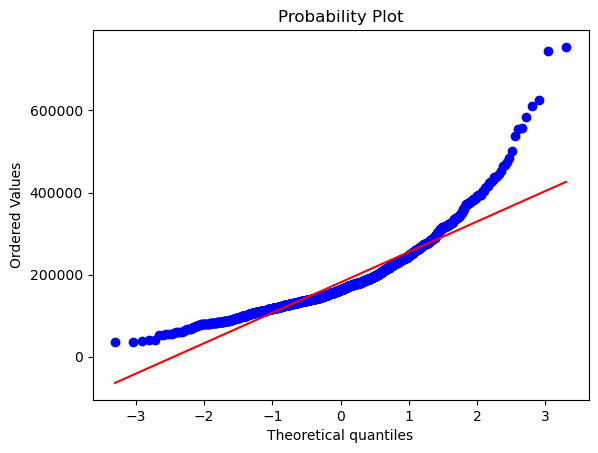

In [30]:
stats.probplot(house_train['SalePrice'], dist='norm', plot=plt);

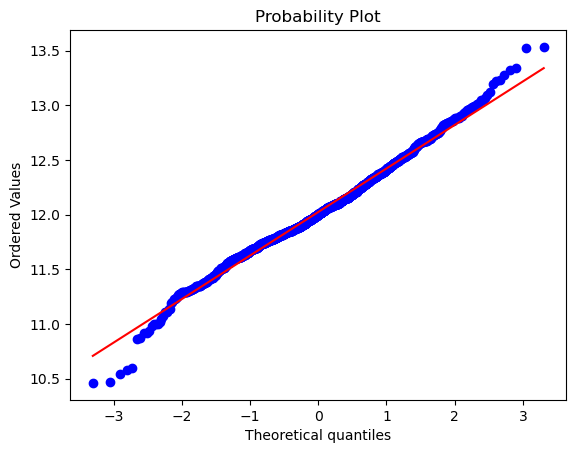

In [31]:
stats.probplot(np.log(house_train['SalePrice']), dist='norm', plot=plt);

### 3.1.2 Histograms

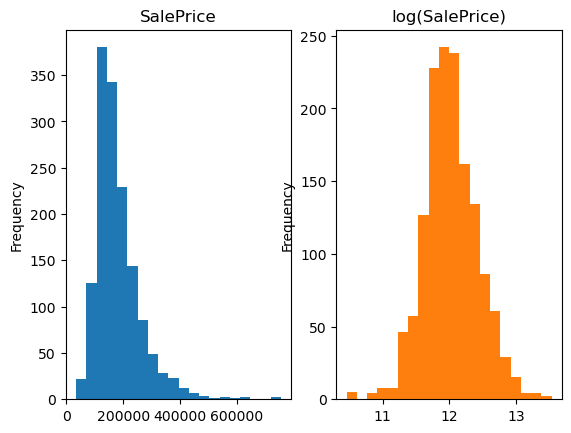

In [32]:
# SalePrice
# Take a look at the distribution of the target variable
fig,ax = plt.subplots(1,2, sharex=False)
house_train["SalePrice"].plot(kind="hist", ax=ax[0], color='tab:blue', title="SalePrice", bins=20)
np.log(house_train["SalePrice"]).plot(kind="hist", ax=ax[1], color='tab:orange', title="log(SalePrice)", bins=20);

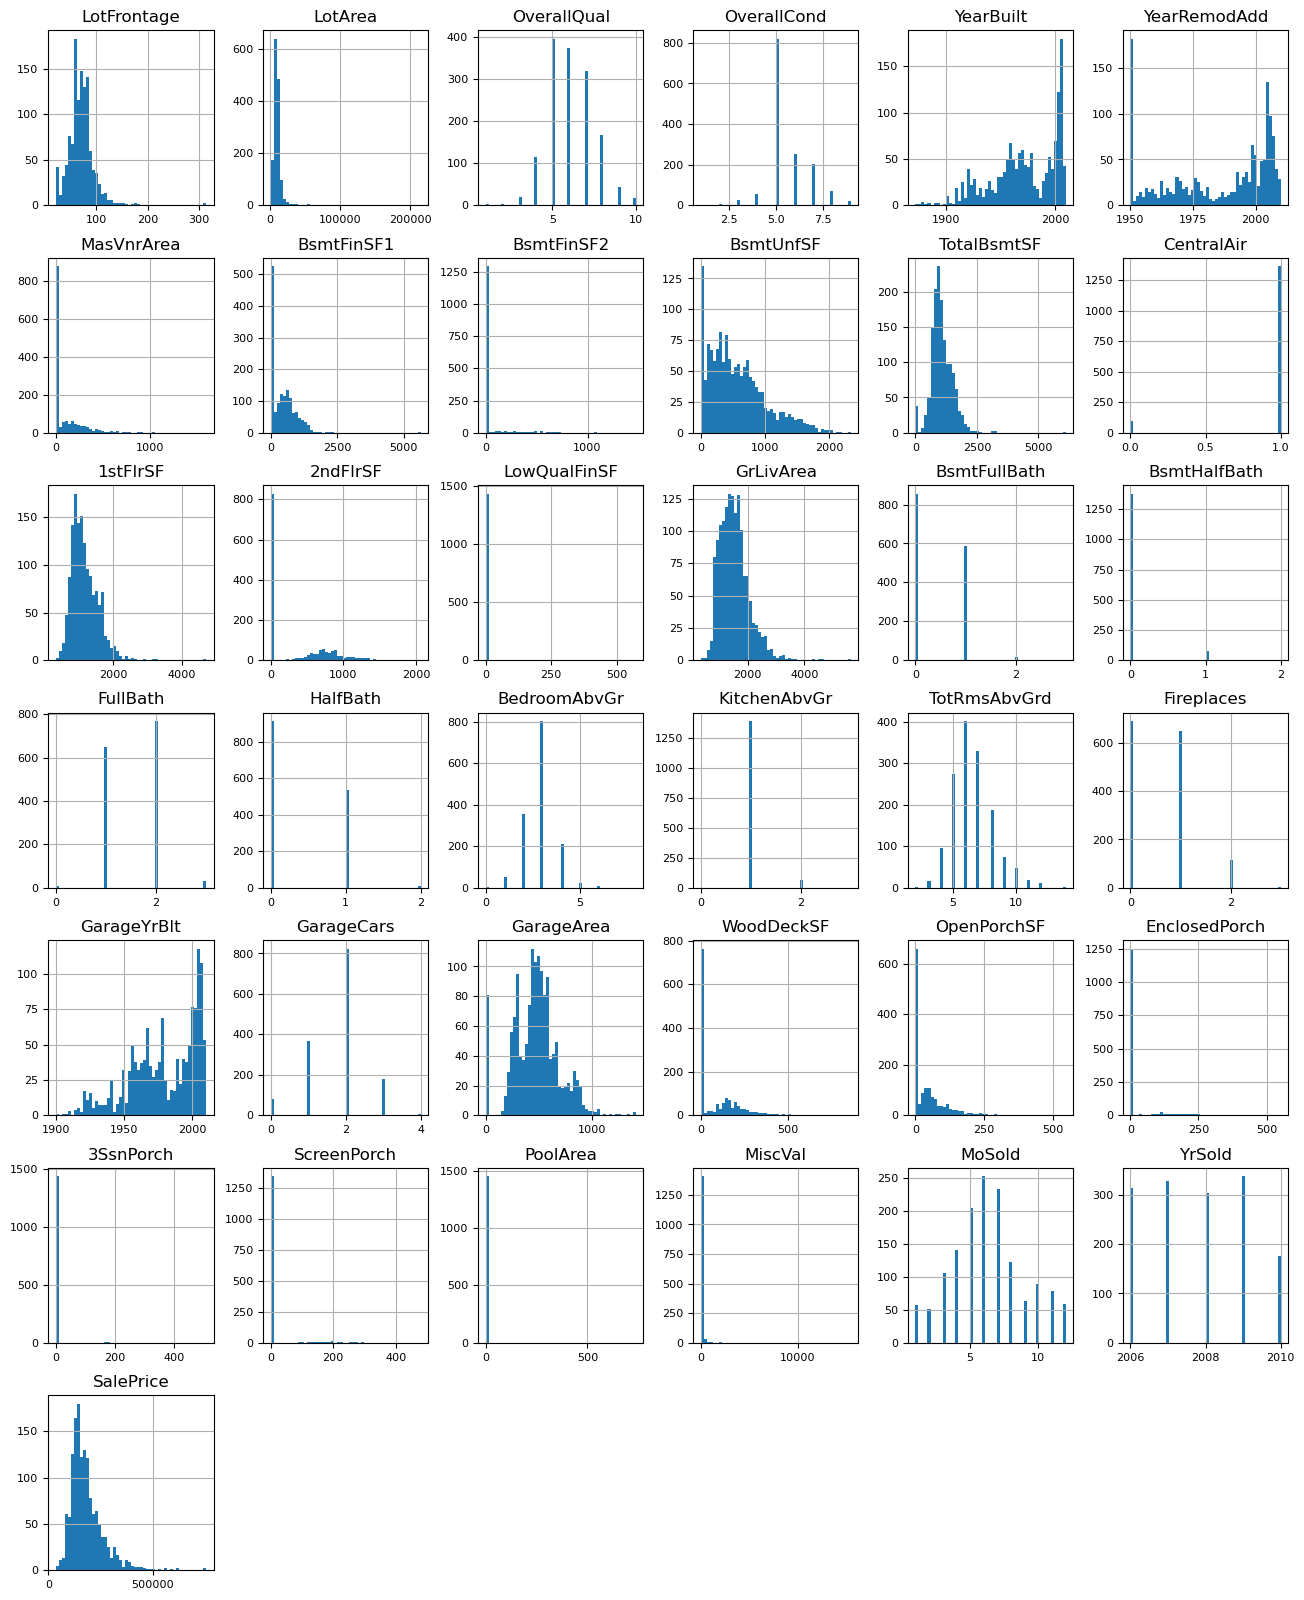

In [33]:
# Look at distributions of all numeric data
house_train[numerics].hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

## 3.2 Understand features in terms of SalePrice

In [34]:
def facet_plotter(pdf:pd.DataFrame, x_vars:list, y_var:str, col_wrap:int=4):
    g = sns.FacetGrid(pd.DataFrame(x_vars), col=0, col_wrap=col_wrap, sharex=False)
    for ax, x_var in zip(g.axes, x_vars):
        sns.boxplot(data=pdf, x=x_var, y=y_var, ax=ax)
    g.tight_layout()

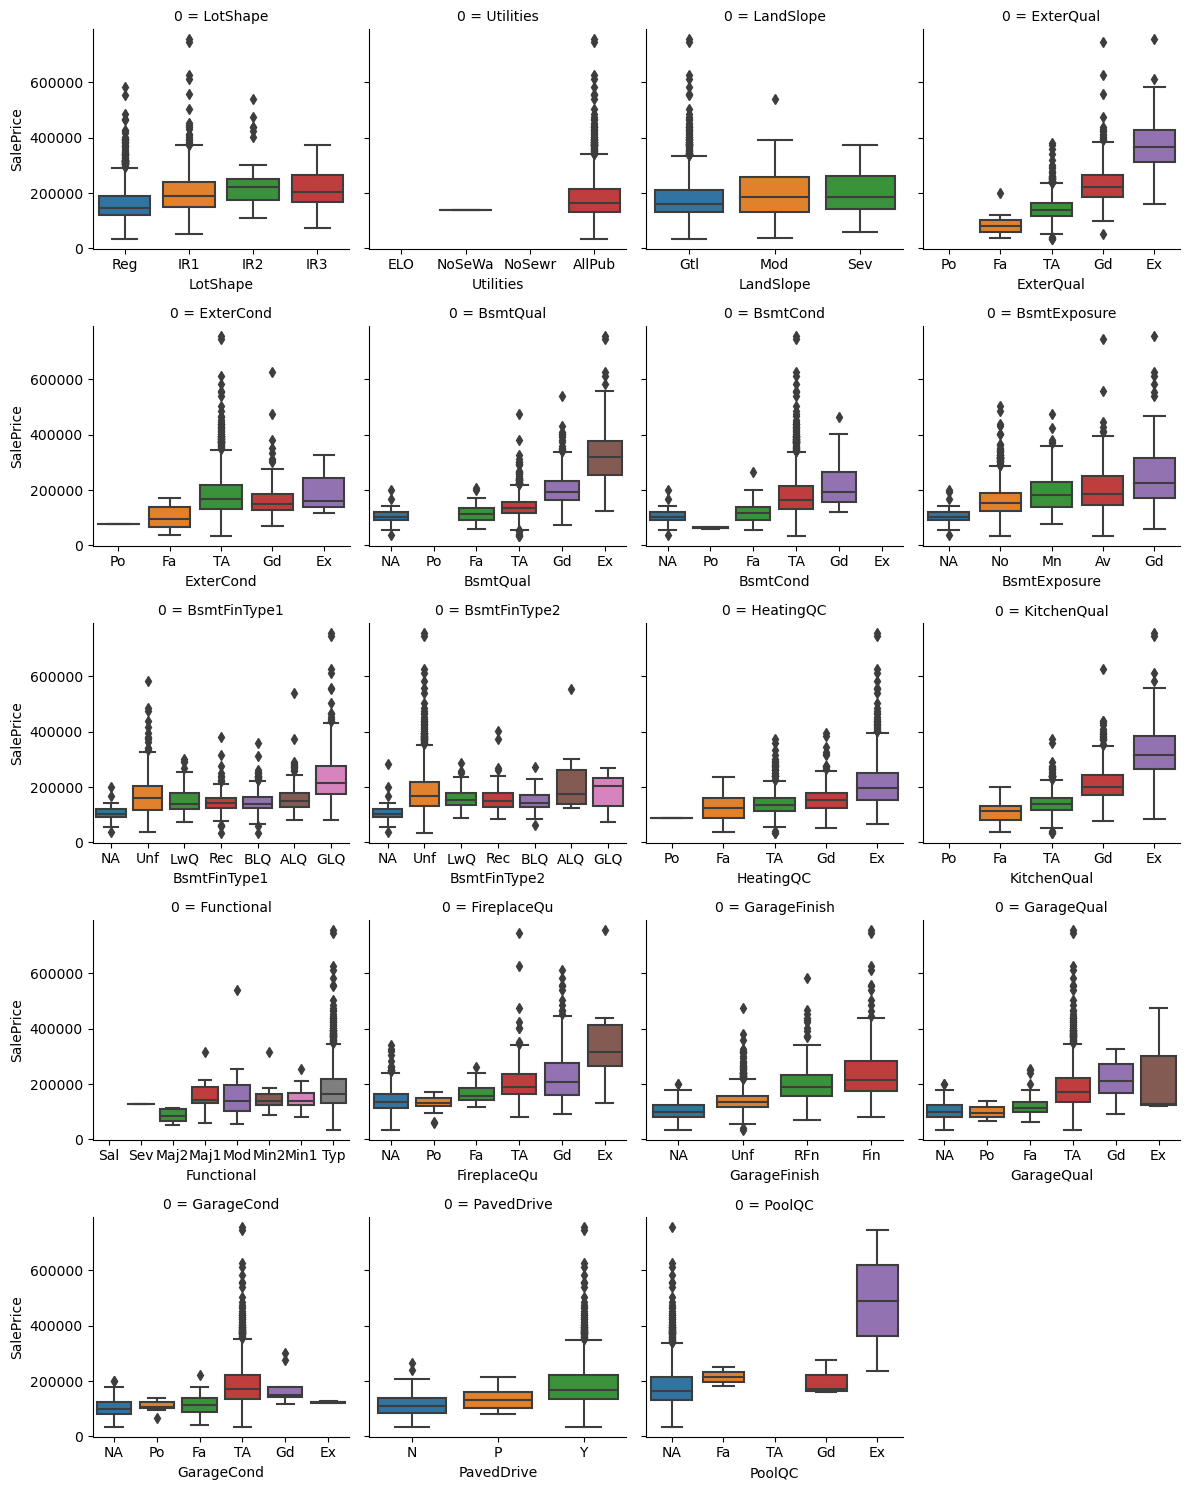

In [35]:
# Look at Ordinals in terms of sames price
facet_plotter(house_train, ordinal_lu.keys(), "SalePrice")

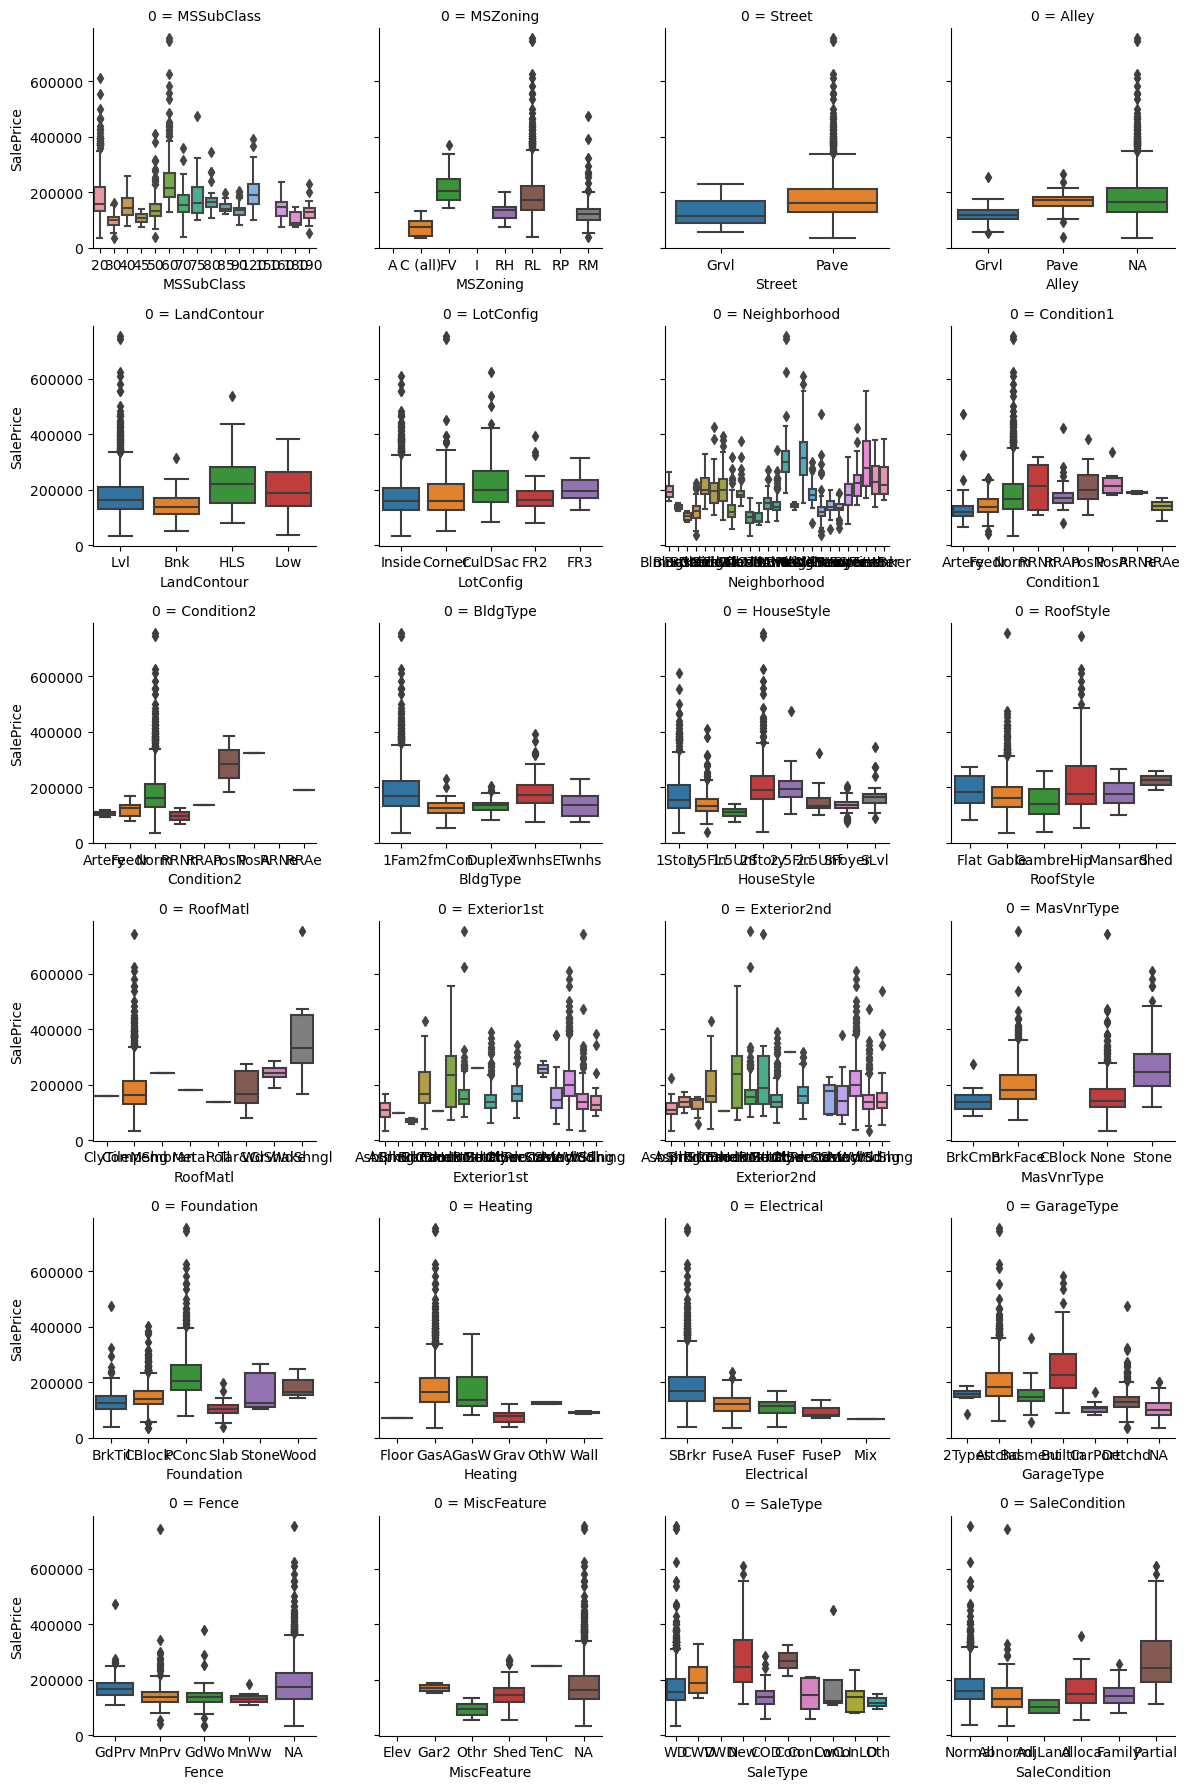

In [36]:
# Nominals
facet_plotter(house_train, nominal_lu.keys(), "SalePrice")

c:\Users\abpmaq5\AppData\Local\anaconda3\envs\absa_data_bootcamp_2023\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: divide by zero encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
c:\Users\abpmaq5\AppData\Local\anaconda3\envs\absa_data_bootcamp_2023\lib\site-packages\statsmodels\nonparametric\smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


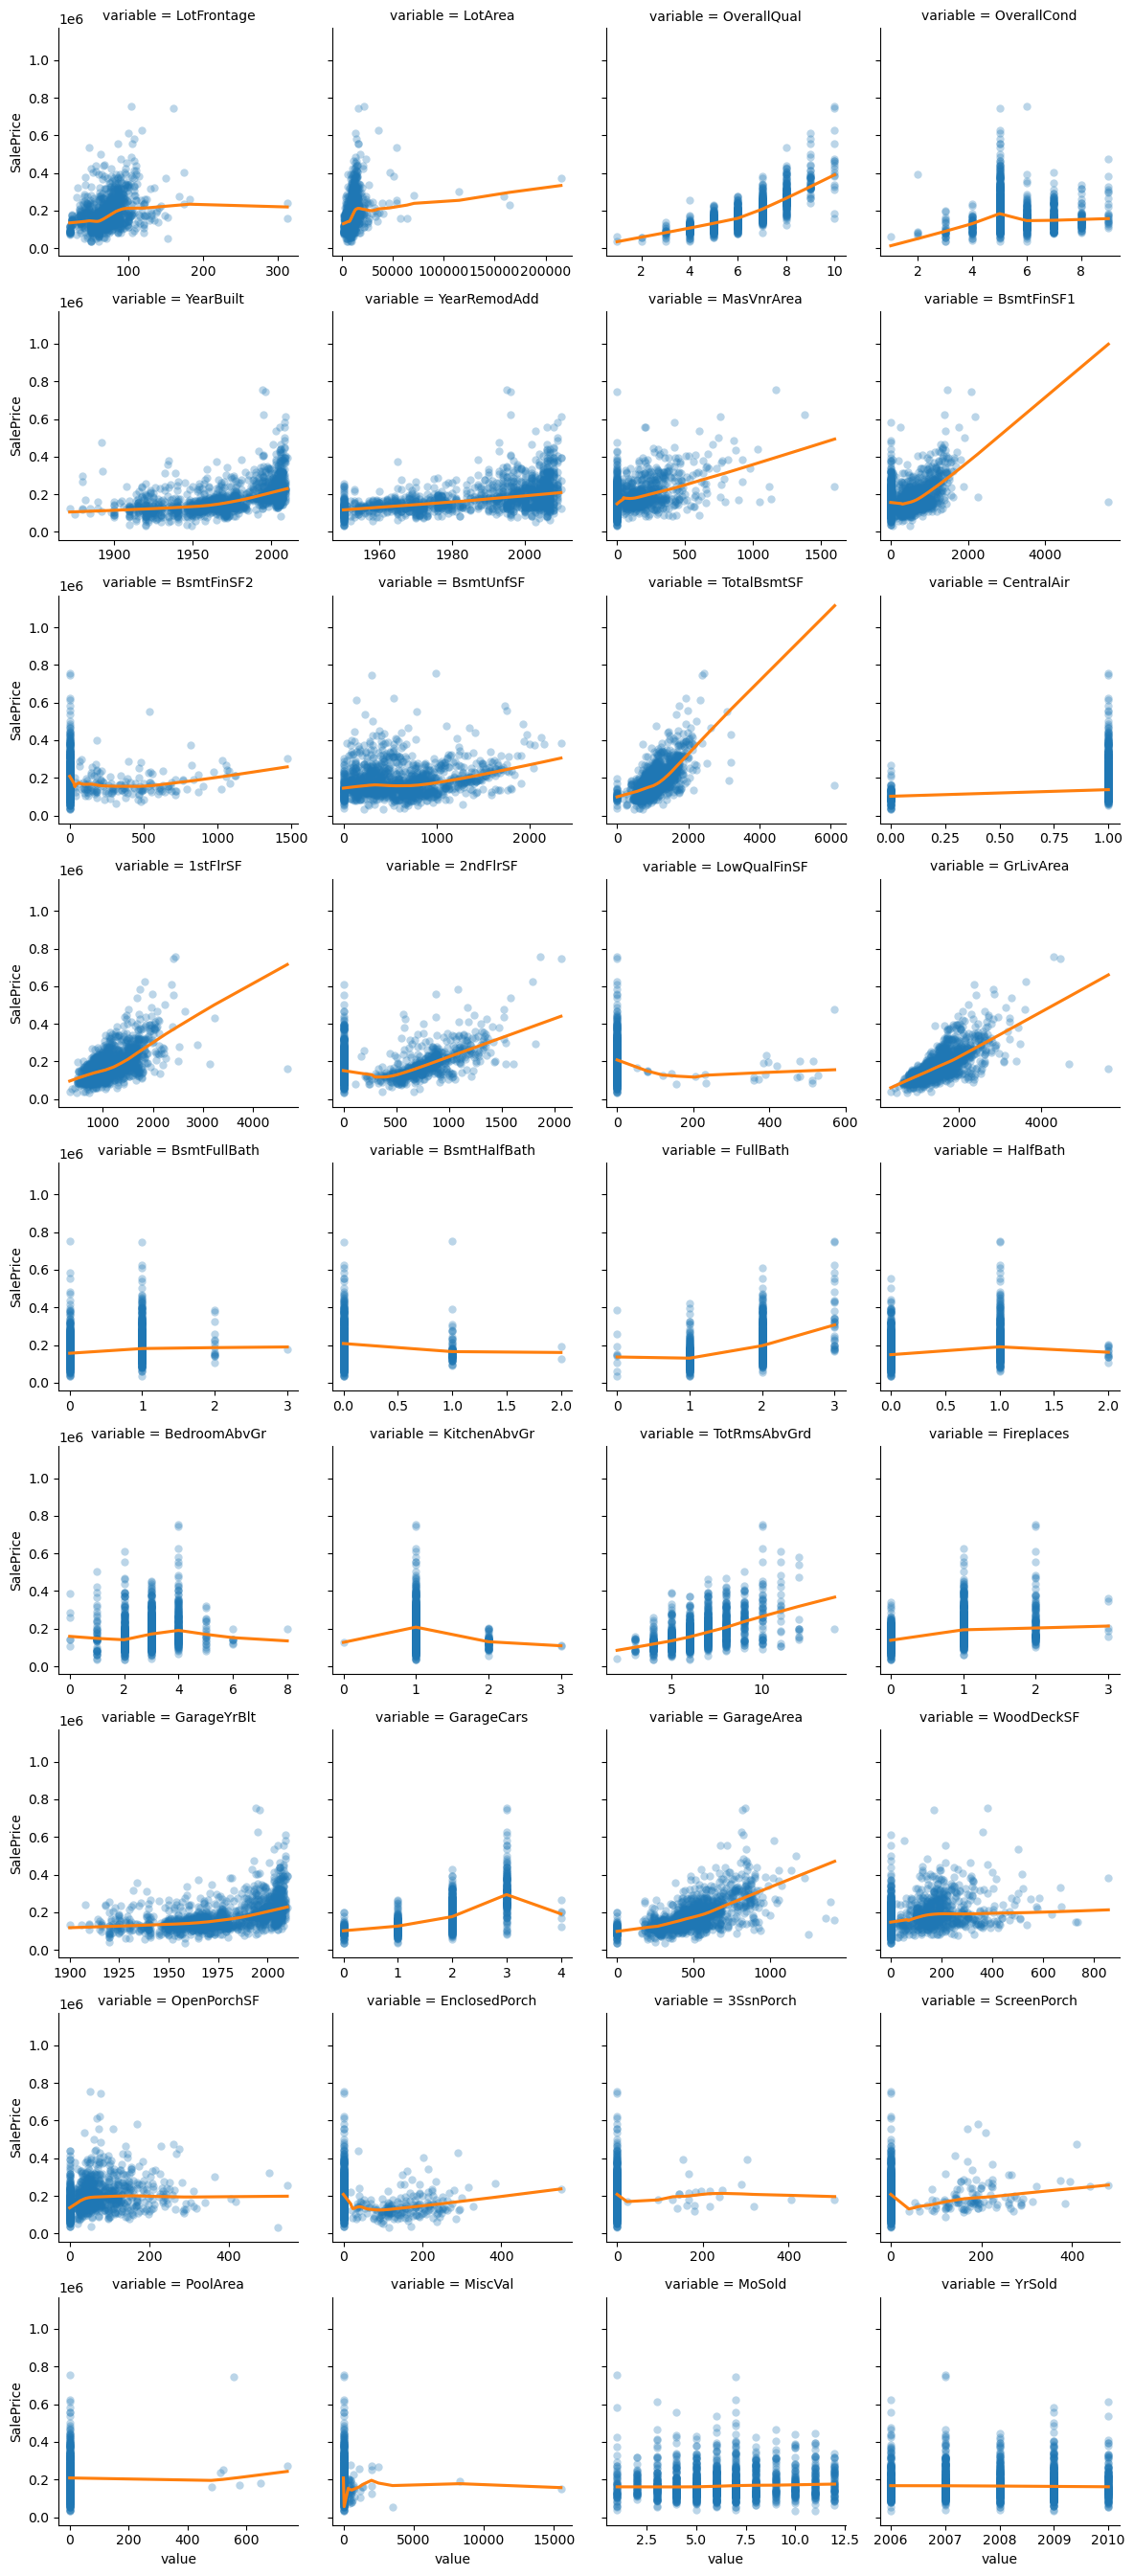

In [37]:
# Numeric variables
f = pd.melt(house_train, id_vars=['SalePrice'], value_vars=numerics)
sns.lmplot(
    data=f, x="value", y='SalePrice', col="variable", lowess=True, 
    col_wrap=4, height=3, aspect=1,scatter_kws={'alpha':0.3, "linewidth":0}, line_kws={"color": "C1"}, facet_kws={"sharex": False});

## 3.3 Correlations
### 3.3.1 Correlations between Continuous Variables

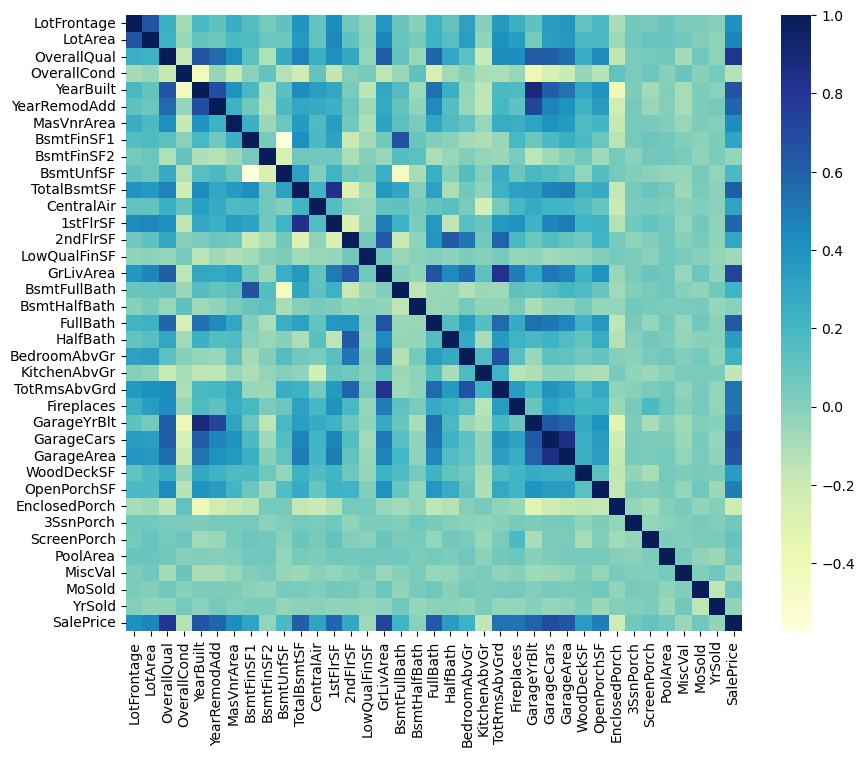

In [38]:
corrmat = house_train[numerics].corr(method='spearman')
plt.subplots(figsize=(10, 8))
sns.heatmap(corrmat, annot=False, cmap="YlGnBu", square=True);

### 3.3.2 Correlations between Ordinal Variables

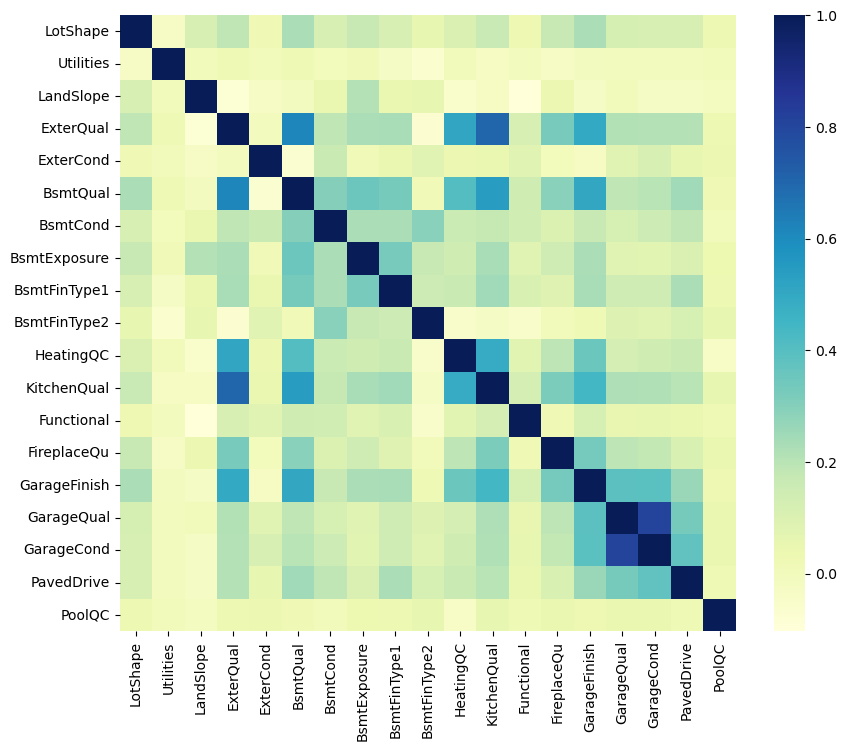

In [39]:
# Create a temporary datframe containing the ordinal order values
pdf_tmp = house_train[ordinal_lu.keys()].copy()
for c in ordinal_lu.keys():
    pdf_tmp[c] = pdf_tmp[c].cat.codes
corrmat = pdf_tmp.corr(method='kendall')
plt.subplots(figsize=(10, 8))
sns.heatmap(corrmat, annot=False, cmap="YlGnBu", square=True);

## 3.4 Correlations with SalePrice
### 3.4.1 Ordinals with SalePrice
Spearmans Rank Correlation, good for continuous and ordinal, robust to outliers, but **assumes linearity**

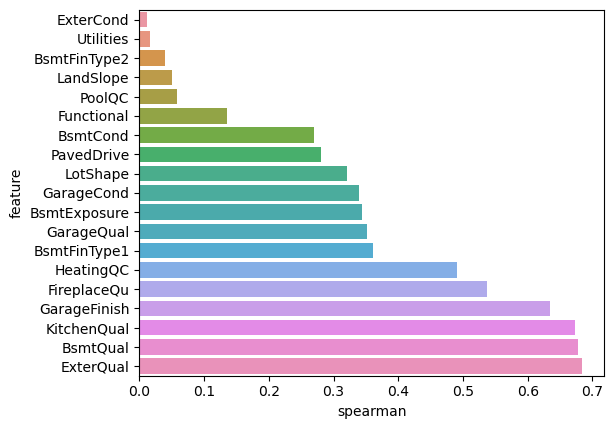

In [40]:
# function to calculate correlations between features and SalePrice
def spearman_categoricals(pdf, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [pdf[f].cat.codes.corr(pdf['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
spearman_categoricals(house_train, ordinal_lu.keys())

### 3.4.2 Numerics with SalePrice

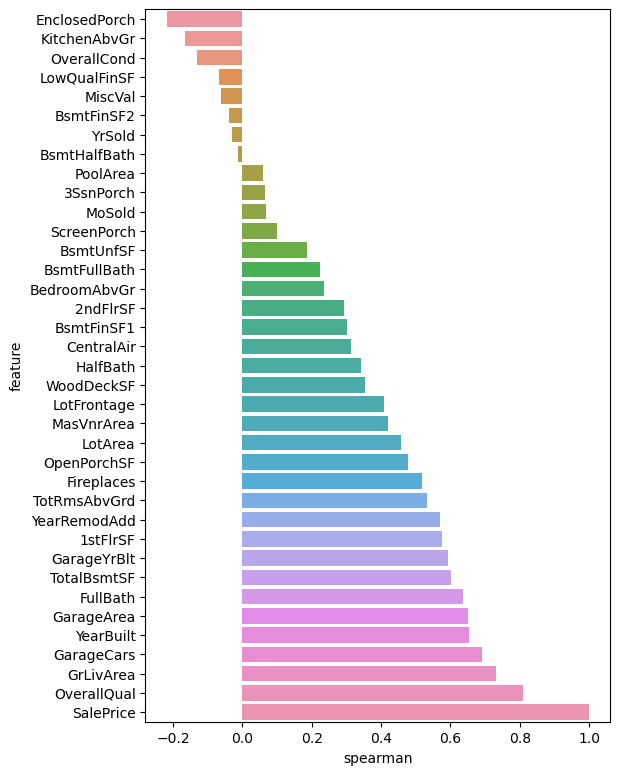

In [41]:
# function to calculate correlations between features and SalePrice
def spearman_numerics(pdf, features):
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [pdf[f].corr(pdf['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
spearman_numerics(house_train, numerics)

# 4. Pre-Processing
## 4.1 Understanding missingness

In [42]:
house_train = pd.read_pickle(Path("house_train_tidy.pkl"))
house_test = pd.read_pickle(Path("house_test_tidy.pkl"))

,Total,Percent
LotFrontage,259,17.74
GarageYrBlt,81,5.55
MasVnrArea,8,0.55
Electrical,1,0.07


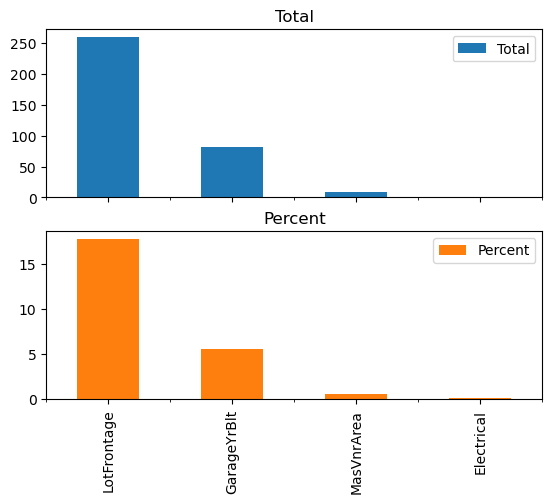

In [43]:
def missing_plotter(pdf):
    total = pdf.isnull().sum().sort_values(ascending=False)
    percent = (pdf.isnull().sum()/pdf.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, round(percent*100,2)], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data[missing_data.Total>=1]
    if len(missing_data) > 0:
        missing_data.plot.bar(subplots=True); # Pandas
    else:
        print("No missing data")
    return(missing_data)
missing_plotter(house_train)

,Total,Percent
LotFrontage,227,15.56
GarageYrBlt,78,5.35
MasVnrArea,15,1.03
MSZoning,4,0.27
BsmtFullBath,2,0.14


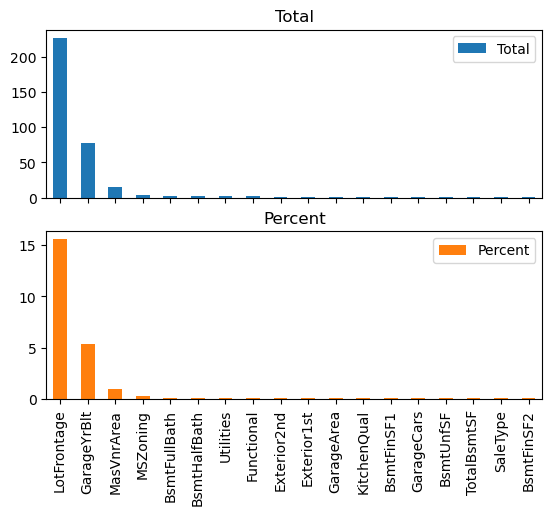

In [44]:
missing_plotter(house_test)[:5]

## 4.2 Dealing with some missing data
GarageYrBlt - numeric, we will impute that a little later on

## 4.2 LotFrontage

In [45]:
pdf=house_train.copy()
pdf["frontage"] = pdf["LotFrontage"].apply(lambda x: 1 if x>0 else x)
pdf.groupby(["LotConfig", "frontage"], dropna=False).size()

LotConfig  frontage
Inside     NaN         134
           1.0         918
Corner     NaN          62
           1.0         201
CulDSac    NaN          49
           1.0          45
FR2        NaN          14
           1.0          33
FR3        NaN           0
           1.0           4
dtype: int64

missing data across all config sizes. We will impute this below

## 4.3 Missing Pattern of GarageYrBlt and some feature engineering

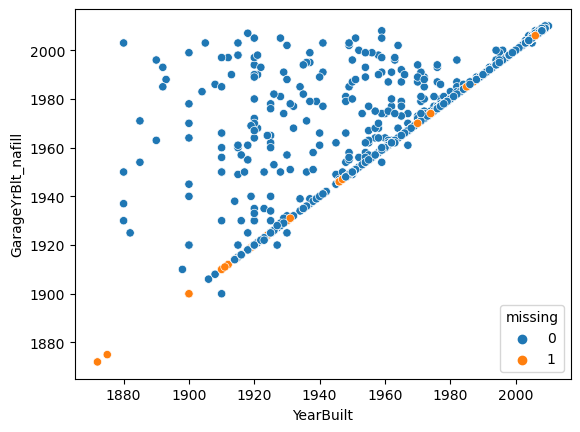

In [47]:
# How does GarageYrBlt relate to YearBuilt?
plt_data = house_train[["YearBuilt", "GarageYrBlt"]].copy()
plt_data["GarageYrBlt_nafill"] = plt_data["GarageYrBlt"].fillna(plt_data["YearBuilt"])
plt_data["missing"] = plt_data["GarageYrBlt"].apply(lambda x: 1 if pd.isnull(x) else 0)

sns.scatterplot(data=plt_data, x="YearBuilt", y="GarageYrBlt_nafill", hue="missing");
# Looks like, in most cases, garages are built when the houses are built

### 4.3.1 Transforming GarageYrBlt

- What does missing data here mean? likely that there is no garage
- We will try and capture the information in GarageYrBlt in 2 other variables
    - **hasGarage**: indicates whether there is a garage or not
    - **GarageBlt**: years + 1 after construction that the garage was built. 
        - 0 indicates no garage, + integer indicates garage built after years + 1

In [48]:
## Create new feature: hasGarage
## Impute GarageYrBlt with YearBuilt

def garage_feat(pdf:pd.DataFrame) -> pd.DataFrame:
    # hasGarage: 0 or 1
    pdf["hasGarage"] = [0 if pd.isnull(x) else 1 for x in pdf["GarageYrBlt"]]

    # GarageBlt
    pdf["GarageBlt"] = pdf["GarageYrBlt"] - pdf["YearBuilt"] + 1
    pdf.loc[pdf["GarageYrBlt"].isna(), "GarageBlt"] = 0
    pdf = pdf.drop(columns=["GarageYrBlt"])
    return(pdf)

house_train = garage_feat(house_train.copy())
house_test = garage_feat(house_test.copy())


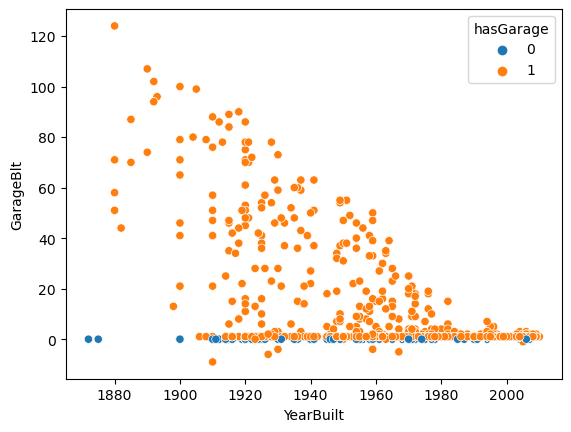

In [49]:
sns.scatterplot(data=house_train, x="YearBuilt", y="GarageBlt", hue="hasGarage");

## 4.5 Low Variance Predictors

In [50]:
def nearZeroVar(pdf, features, freqCut=95/5, uniqueCut=10):
    features = list(features)

    n_unique = []
    freqRatio = []
    percentUnique = []
    for f in features:
        tmp = pdf.groupby(f).size()
        tmp = tmp[tmp>0].sort_values(ascending=False).reset_index(drop=True)
        n_unique.append(len(tmp))
        freqRatio.append(tmp[0]/tmp[1])
        percentUnique.append((len(tmp)/len(pdf[f]))*100)

    res = pd.DataFrame()
    res['feature'] = features
    res['freqRatio'] = freqRatio
    res['percentUnique'] = percentUnique

    res["zeroVar"] = [True if i == 1 else False for i in n_unique]
    res["nzv"] = (res['freqRatio'] > freqCut) & (res['percentUnique'] < uniqueCut)

    return(res)

In [51]:
nzv = nearZeroVar(house_train, house_train.columns, freqCut=99/1, uniqueCut=5)
nzv = nzv[nzv["nzv"]]
nzv

,feature,freqRatio,percentUnique,zeroVar,nzv
5,Street,242.333333,0.136986,False,True
9,Utilities,1459.000000,0.136986,False,True
14,Condition2,240.833333,0.547945,False,True
22,RoofMatl,130.363636,0.547945,False,True
45,LowQualFinSF,478.000000,1.643836,False,True
68,3SsnPorch,478.666667,1.369863,False,True
70,PoolArea,1453.000000,0.547945,False,True
71,PoolQC,484.333333,0.273973,False,True
74,MiscVal,128.000000,1.438356,False,True


In [52]:
# Drop these
house_train = house_train.drop(columns=nzv["feature"])

## 4.6 Imputing other missing data using KNN and Mode

In [53]:
from sklearn.impute import KNNImputer, SimpleImputer

# KNN imputer for numeric values
imputer_num = KNNImputer(n_neighbors=5)

# Simple mode imputer for categoricals
# imputer_cat = SimpleImputer(strategy="most_frequent") # dont use as it drops catagorical info, roll your own
def mode_imputer(pdf):
    modes = pdf.mode().T
    for f in pdf.columns:
        pdf[f] = pdf[f].fillna(modes.loc[f][0])
    return(pdf)


In [54]:
def imputer(pdf:pd.DataFrame):
    # Columns have changed since we first identified all the types, so re-ID numeric vs categorical features
    numeric_cols = pdf.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = [c for c in pdf.columns if c not in numeric_cols]

    # Impute missing values separately
    pdf_num_imputed = pd.DataFrame(imputer_num.fit_transform(pdf[numeric_cols]), columns=numeric_cols)
    pdf_cat_imputed = mode_imputer(pdf[categorical_cols].copy())

    # Join the imputed versions back together
    pdf_concat = pd.concat([pdf_num_imputed, pdf_cat_imputed], axis=1)
    pdf_concat["Id"] = pdf_concat["Id"].astype(int)
    return(pdf_concat)

In [57]:
house_train = imputer(house_train)
house_test = imputer(house_test)

In [60]:
# Look at missing again
display(missing_plotter(house_train)[:5])
display(missing_plotter(house_test)[:5])

No missing data


,Total,Percent


No missing data


,Total,Percent


## 4.4 More Feature engineering: Transforming YearRemodAdd
- Remodel date (same as construction date if no remodeling or additions)

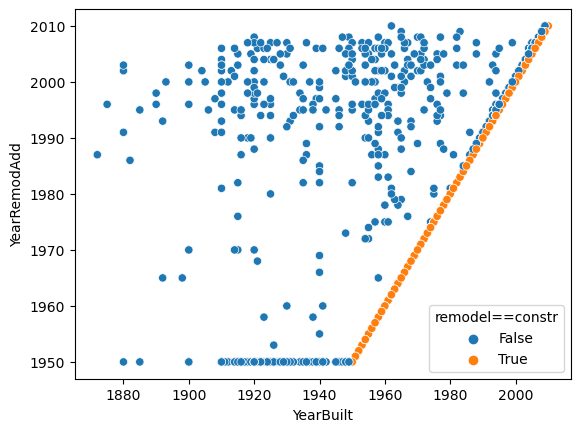

In [61]:
plt_data = house_train[["YearBuilt", "YearRemodAdd"]].copy()
plt_data["remodel==constr"] = plt_data["YearRemodAdd"]==plt_data["YearBuilt"]
plt_data["remodel==constr"]

sns.scatterplot(data=plt_data, x="YearBuilt", y="YearRemodAdd", hue="remodel==constr");

### 4.4.1 Create new features from YearRemodAdd
- it looks like many houses built before 1950 was remodelled in 1950 - unlikely, lets assume that if a house was built before 1950, and remodelled in 1950, in fact it was never remodelled and someone simply used 1950 as a default settign for all those houses.

- We will try and capture the information in YearRemodAdd in 2 other variables
    - **isRemod**: indicates whether the house is remodelled
    - **RemodAdd**: years + 1 after construction that the house was remodelled. 
        - 0 indicates no remodel, + integer indicates remodelled after years + 1

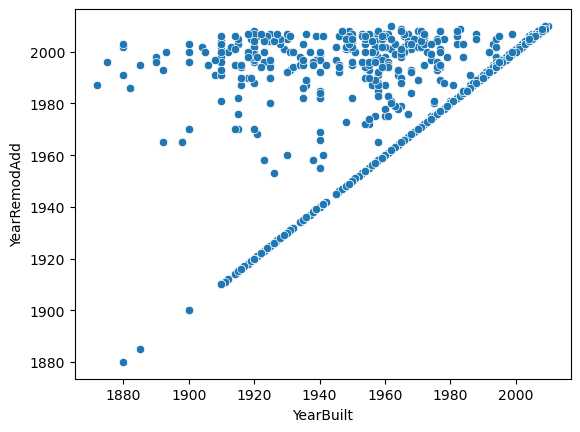

In [62]:
pdf = house_train.copy()
pdf.loc[pdf["YearRemodAdd"] == 1950, "YearRemodAdd"] = pdf.loc[pdf["YearRemodAdd"] == 1950, "YearBuilt"]
sns.scatterplot(data=pdf, x="YearBuilt", y="YearRemodAdd");


In [63]:
def remod_feat(pdf:pd.DataFrame) -> pd.DataFrame:
    # Correct remodelling date for 1950 remodelled
    pdf.loc[pdf["YearRemodAdd"] == 1950, "YearRemodAdd"] = pdf.loc[pdf["YearRemodAdd"] == 1950, "YearBuilt"]
    pdf["isRemod"] = (pdf["YearRemodAdd"]==pdf["YearBuilt"]).astype(int)

    pdf["RemodAdd"] = pdf["YearRemodAdd"] - pdf["YearBuilt"]
    pdf = pdf.drop(columns=["YearRemodAdd"])
    return(pdf)

house_train = remod_feat(house_train.copy())
house_test = remod_feat(house_test.copy())

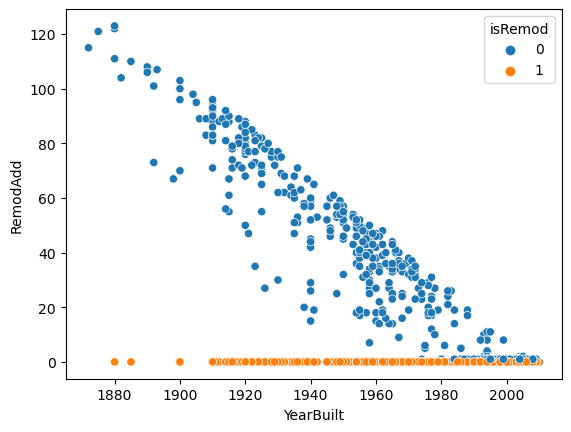

In [64]:
sns.scatterplot(data=house_train, x="YearBuilt", y="RemodAdd", hue="isRemod");

## 4.7 Transforming SalePrice to log scale
Transforms can sometimes help models converge

In [65]:
house_train["logSalePrice"] = np.log(house_train['SalePrice'])

## 4.8 Save data

In [66]:
house_train.to_pickle(Path("house_train_preproc.pkl"))
house_test.to_pickle(Path("house_test_preproc.pkl"))

In [67]:
house_train = pd.read_pickle(Path("house_train_preproc.pkl"))
house_test = pd.read_pickle(Path("house_test_preproc.pkl"))

# 5. Model Training and Parameter Tuning
We will use Microsofts LightGBM framework to build a regression tree model for our data, and then see if we can improve performance via some hyper parameter tuning.
## 5.1 Prepare the dataset for modelling

In [68]:
# ID features and target variables
features = [c for c in house_train.columns if c not in ["Id", "SalePrice", "logSalePrice"]]
target1 = "SalePrice"
target2 = "logSalePrice"

# split into train and validation sets
X, y = house_train[features], house_train[target1]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

## 5.2 Train a vanilla model to set a baseline

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 11284.1	valid_1's rmse: 26242.7

Root Mean Squared Error: 26242.66212766738


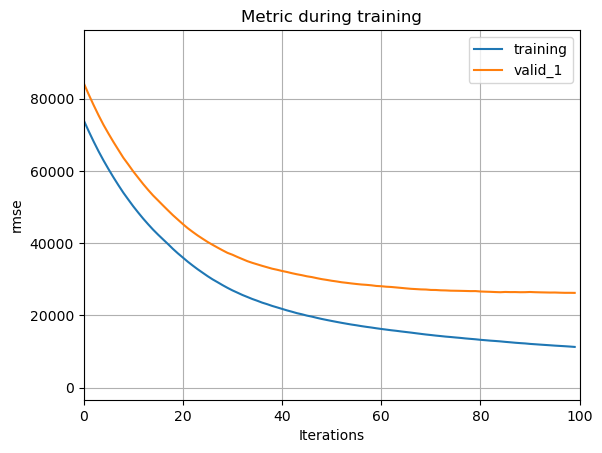

In [69]:
# Quieten some LGBM warnings
warnings.filterwarnings("ignore", category=UserWarning)

# SKLearn API
params = { 
    'boosting': 'gbdt',
    'objective': 'poisson',
    'metric': 'rmse',
    'verbose': -1
}

evals={}
model = lgb.LGBMRegressor(**params)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=-1,
    callbacks=[
        lgb.record_evaluation(evals), 
        lgb.early_stopping(100),
        lgb.log_evaluation(0)
    ], 
)

lgb.plot_metric(evals);

y_pred = model.predict(X_valid)
rmse_vanilla = mean_squared_error(y_valid, y_pred, squared=False)
print("\nRoot Mean Squared Error:", rmse_vanilla)

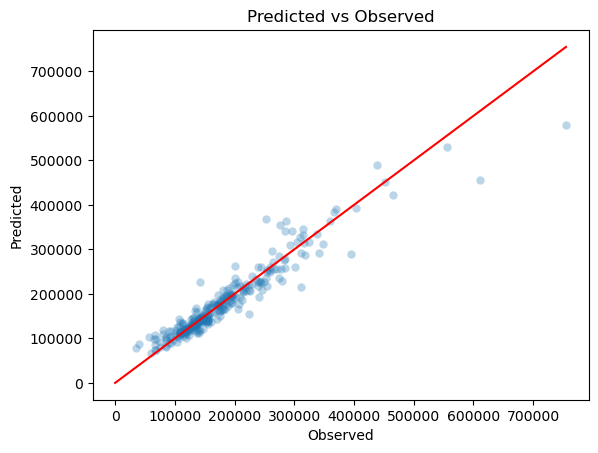

In [70]:
# Predicted vs Observed
plt.scatter(y_valid, y_pred, alpha=.3, linewidth=0)
plt.plot([0,max(y_valid)], [0, max(y_valid)], color="red")
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Predicted vs Observed")
plt.show()

## 5.3 Feature importance
Lets find out whether we can perhaps ignore some of our features, building simpler better models

In [71]:
def feat_imp_plotter(m, topn=0):
    feature_imp = pd.DataFrame({'importance':m.feature_importances_}, index=m.feature_name_)\
        .sort_values("importance")
    if topn > 0:
        feature_imp = feature_imp.tail(topn)
        height = math.ceil(topn/5)
    else:
        feature_imp = feature_imp[feature_imp["importance"] > 0]
        height = int(len(feature_imp)/5)
    feature_imp = feature_imp[feature_imp["importance"] > 0]
    tot = feature_imp["importance"].sum()
    feature_imp["cumulative_importance_percent"] = ((feature_imp['importance'][::-1]/tot)*100).cumsum()
    feature_imp.plot.barh(subplots=True, sharex=False, sharey=True, layout=(1,2), figsize=(10,height))
    return(feature_imp)
    

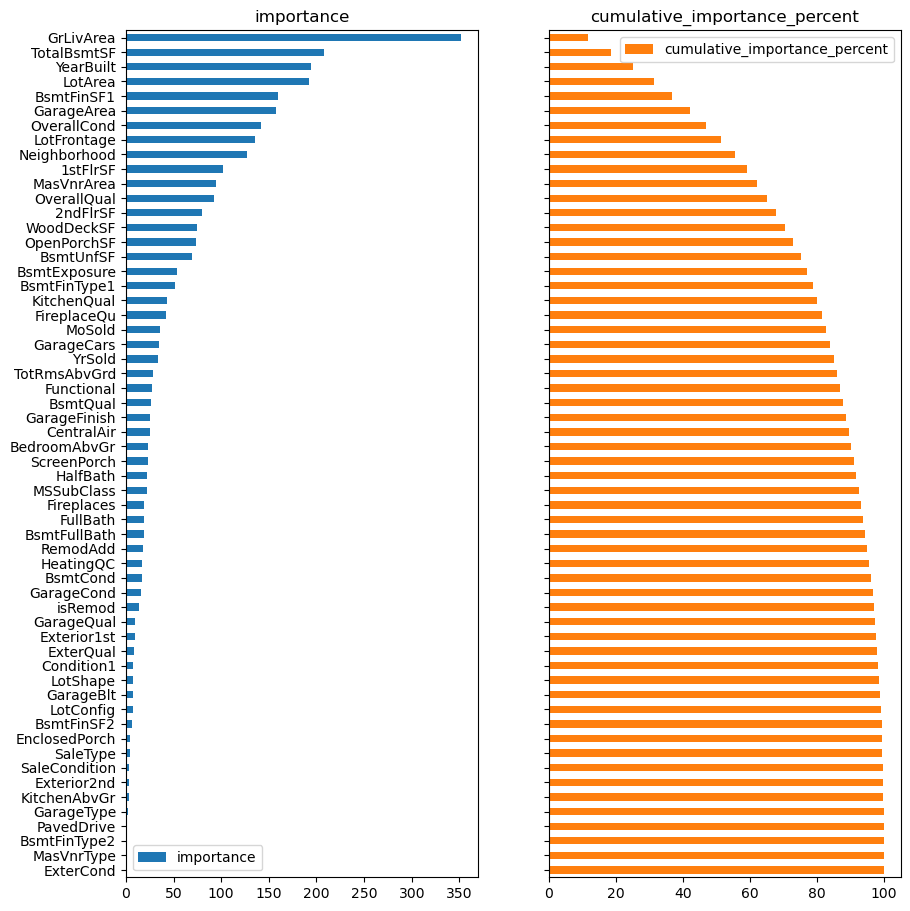

In [72]:
feature_imp = feat_imp_plotter(model)

### 5.3.1 Test model performance with fewer metrics
Lets get a general idea what happens if we drop some less important features... This can be useful when you have many thousands of features, and need a simpler faster model.

Generally it's at the expense of some score-performance, but that is ok sometimes.

In [73]:
# Small helper function to quickly train and test the impact of feature changes on model performance
def model_feat_test(feature_imp, cutoff):
    # ID features and target variables
    features = list(feature_imp.loc[feature_imp["cumulative_importance_percent"]<=cutoff].index)
    target = "SalePrice"

    # split into train and validation sets
    X, y = house_train[features], house_train[target]
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

    # SKLearn API
    params = { 
        'boosting': 'gbdt',
        'objective': 'poisson',
        'metric': 'rmse',
        'verbose': -1
    }

    model = lgb.LGBMRegressor(**params)    
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        verbose=-1,
        callbacks=[
            lgb.early_stopping(100),
            lgb.log_evaluation(0)
        ], 
    )

    y_pred = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, y_pred, squared=False)
    
    return(rmse)


In [74]:
# display(feature_imp.tail())

cutoffs = [85, 90, 95, 100]
results = pd.DataFrame({'rmse':np.nan}, index=cutoffs)
# results.loc[85]["rmse"] = 5
# results
for cutoff in cutoffs:
    results.loc[cutoff]["rmse"] = model_feat_test(feature_imp, cutoff)
    # results.append(model_feat_test(feature_imp, cutoff))

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 12020.2	valid_1's rmse: 27213.6
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 11815.7	valid_1's rmse: 26843.8
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[100]	training's rmse: 11394.5	valid_1's rmse: 26185.4
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
Training until validation scores don't improve for 100 rounds
Did not mee

In [75]:
display(results)
rmse_feat = results['rmse'].min()
print(f"To beat: {rmse_vanilla}")
print(f"best: {rmse_feat}")

,rmse
85,27213.616880
90,26843.792762
95,26185.388657
100,26238.926247


To beat: 26242.66212766738
best: 26185.388656724557


Trimming off features which contribute to our model has an impact on score as expected, but trimming off zero contributing features actually improved the score a bit, so lets do that.

### 5.3.2 Retain only contributing features

In [76]:
features = list(feature_imp.index)
target1 = "SalePrice"
target2 = "logSalePrice"

# Split the features from the target variable
X, y = house_train[features], house_train[target1]

## 5.4 Hyperparameter tuning and Cross validation
Hyperparameter tuning: testing various combinations of model parameters, looking for optima

Cross validation: measuring model parameter performance across subsets of your data to measure performance and importantly stability

### 5.4.1 Use Optuna to manage out hyperparameter tuning

In [77]:
# Build OpTunas objective function
def objective(trial, X, y):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    #static parameters
    param_static = { 
        'boosting_type': 'gbdt',
        'objective': 'poisson',
        'metric': 'rmse',
        'verbose': -1,
        'n_estimators': 10000
    }
    
    # the parameter grid from where unique parameters will be drawn
    param_grid = {
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, step=0.001),
        "num_leaves": trial.suggest_int("num_leaves", 20, 60, step=1),
        "max_depth": trial.suggest_int("max_depth", 3, 50)
    }

    # set up cross validation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # for storing scores from the K-Folds
    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgb.LGBMRegressor(
            **param_static, 
            **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric="rmse",
        categorical_feature="auto",
            verbose=-1,
            callbacks=[
                lgb.early_stopping(100, verbose=0),
                lgb.log_evaluation(0)
            ]
        )
        y_pred = model.predict(X_test)
        cv_scores[idx] = mean_squared_error(y_test, y_pred, squared=False)

    return np.mean(cv_scores)
    # return(0)

Run the grid search

In [78]:
# Suppress optuna training logs
optuna.logging.set_verbosity(optuna.logging.WARNING)
# optuna.logging.set_verbosity(optuna.logging.INFO)

# Create an OpTuna study
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")

# Call the Optuna Objective function, and begine some simple hyperparameter tuning
func = lambda trial: objective(trial, X, y)
study.optimize(func, n_trials=200, show_progress_bar=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

**Optuna** has a fey useful canned plots that can show us interesting info about interactions between our hyperparameters.

https://optuna.readthedocs.io/en/stable/reference/visualization/index.html


In [ ]:
# Plot parameter relations as scatter plots with colors indicating ranks of target value.
fig = optuna.visualization.plot_rank(study, target_name="rmse")
fig.show()

### 5.4.1 Train the final model using optimal parameters

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_static = { 
    'boosting_type': 'gbdt',
    'objective': 'poisson',
    'metric': 'rmse',
    'verbose': -1,
    'n_estimators': 10000
}

evals={}
model = lgb.LGBMRegressor(
    **param_static, 
    **study.best_params)
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=-1,
    callbacks=[
        lgb.record_evaluation(evals), 
        lgb.early_stopping(100),
        lgb.log_evaluation(0)
    ], 
)

lgb.plot_metric(evals);

y_pred = model.predict(X_test)
rmse_final = mean_squared_error(y_test, y_pred, squared=False)
print(f"\nTo beat: {rmse_feat}")
print("Root Mean Squared Error:", rmse_final)

Some quick hyperparameter tuning has improves out RMSE score on the validation set.